# Lesson/Article 08 - Bee or Wasp

**Author: Gabriel Moretti de Souza - 200018205**

**Author's GitHub username: MorettiGS**

## HuggingFace

The following is the link for the HuggingFace space regarding this notebook:

[HuggingFace - BeeOrWasp](https://huggingface.co/spaces/MorettiGS/BooksRecommendation)

## Objective

In this article, we are going through the creation and usage of a **classifier** using Artificial Intelligence, with the main purpose of training it to identify an image between __Bee__ or __Wasp__.

For the creation of said classifier, we will be creating a neural network with the help of Convolutional Neural Networks (CNN) that is capable of determining said differences, the idea of this classifier is inspired by the dataset [Bee or Wasp?](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp/data).

This search and results could be useful, in a real life situation, when trying to identify potential benefits or dangers in the rural area each species could bring.

## Pre-requisites

Previous downloads that may be necessary for the dependencies used on the notebook:

In [1]:
# !pip install p5py
# !pip install PEP517
# !pip install gcc
# !pip install pandas
# !pip install kaggle
# !pip install torch
# !pip install fastai
# !pip install scikit-learn
# !pip install -Uqq duckduckgo_search
# !pip install -Uqq fastai?

Before going any further, it is essential that we get the necessary dependencies for the AI training, and these can be found in the Python libraries imported with the code below:

In [2]:
import numpy as np 
import pandas as pd
from time import sleep
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from matplotlib import pyplot as plt
from scipy import signal as sig

## Remove warnings for the whole notebook
import warnings
warnings.filterwarnings('ignore')

In [3]:
## Function to search for images
def search_images(term, max_images=300): return L(ddg_images(term, max_results=max_images)).itemgot('image')

## Image downloading

With the following two cells, we can visualize one example for each of the classes in our classifier: 'bee' and 'wasp'.

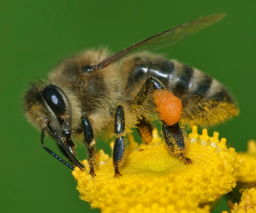

In [4]:
download_url(search_images('bee', max_images=1)[0], 'bee.jpg', show_progress=False)
Image.open('bee.jpg').to_thumb(256,256)

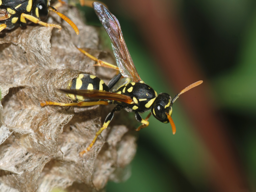

In [5]:
download_url(search_images('wasp', max_images=1)[0], 'wasp.jpg', show_progress=False)
Image.open('wasp.jpg').to_thumb(256,256)

Then we can download the images that will be utilized in our models, adding them to their respective folders in our main directory.

In [6]:
# Download and resize images
searches = 'bee','wasp'
path = Path('beeOrWasp')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(1)  
    resize_images(path/o, max_size=400, dest=path/o)

Now we can just verify our images and take off failed ones.

In [7]:
## Showing the number of failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

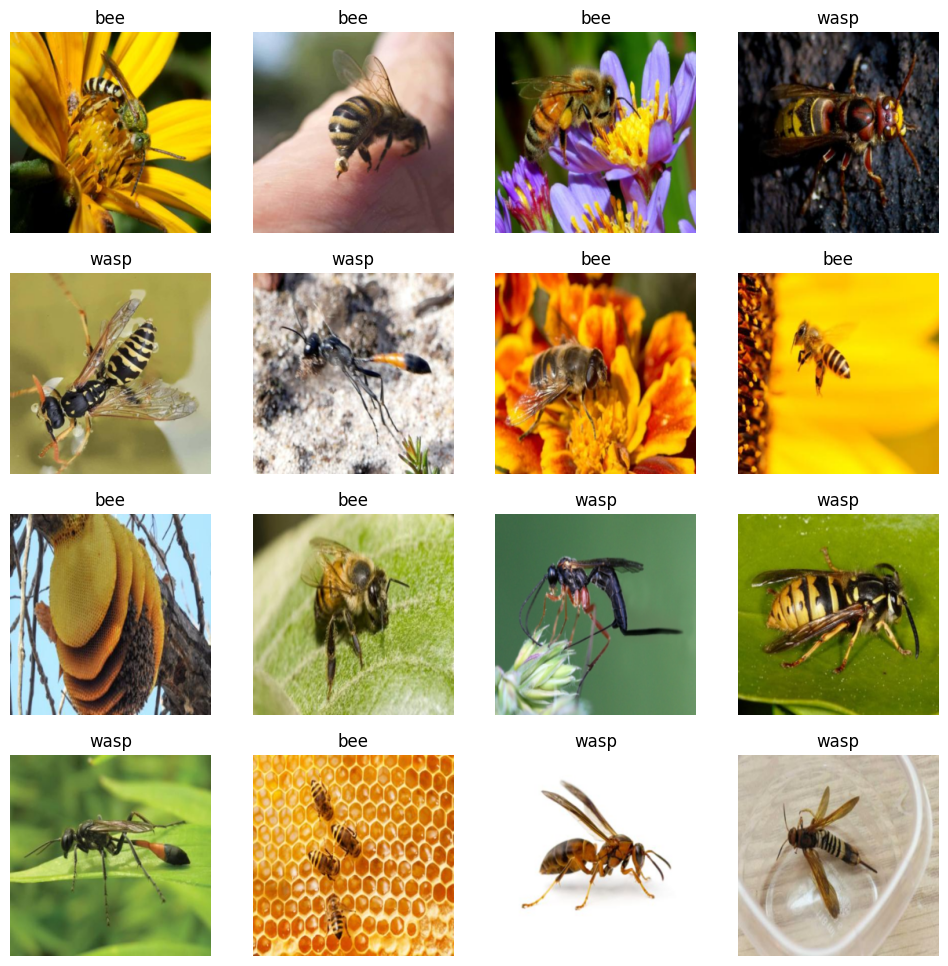

In [8]:
## Creating data for the models
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=16)

dls.show_batch(max_n=16)

## Convolution

Convolution can be understood as a mathematical method that combines two functions to create a third function by calculating the weighted average of the product of these functions at different positions. In image processing, this involves overlaying a filter onto an image and performing a point-wise multiplication operation between the filter and the image. This multiplication is carried out in different regions of the image by shifting the overlay, resulting in a transformed image. The choice and configuration of the filter can produce various effects such as blurring, color adjustments, edge detection, and other visual manipulations.

The code cell below loads an image, resizes it to 32x32 pixels, converts it to a NumPy array, and displays the original and resized images side by side using the Matplotlib library:

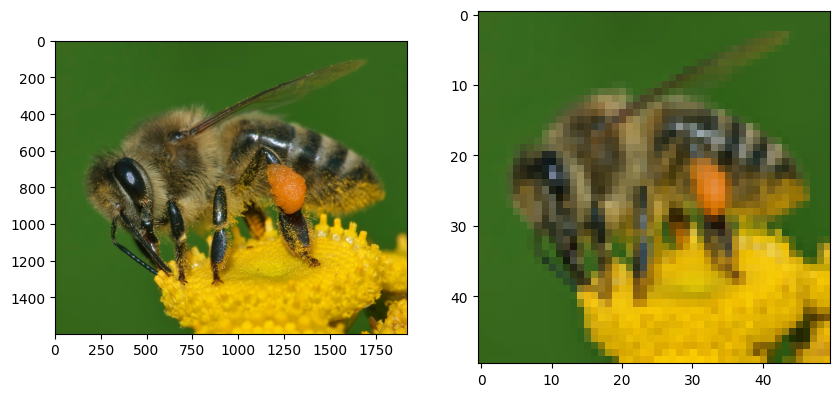

In [17]:
# Resize image
im = Image.open(r'bee.jpg')
newsize = (50, 50)
im2 = im.resize(newsize)
img = np.asarray(im2)

# Convert image to numpy array
original = np.asarray(im, dtype=np.uint8)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(original)
axs[1].imshow(img)

The cell below defines a 3x3x3 filter (3 dimensions for RGB colors) with specific values to desaturate the image while maintaining an emphasis on the color green.

In [18]:
# Create filter for dessaturation
filter_1 = np.zeros((3,3,3), dtype=float)

filter_1[1][1][0] = 0.4
filter_1[1][1][1] = 0.4
filter_1[1][1][2] = 0.3

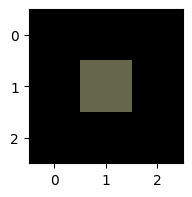

In [19]:
# Show created filter
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.imshow(filter_1)

In [20]:
img_2 = np.zeros((50,50,3), dtype=float)

for i in range(50):
    for j in range(50):
        img_2[i][j][0] = img[:,:,0][i][j] * 0.4
        img_2[i][j][1] = img[:,:,1][i][j] * 0.3
        img_2[i][j][2] = img[:,:,2][i][j] * 0.3

img_2 = np.asarray(img_2, dtype=np.uint8)
np.shape(img_2)

(50, 50, 3)

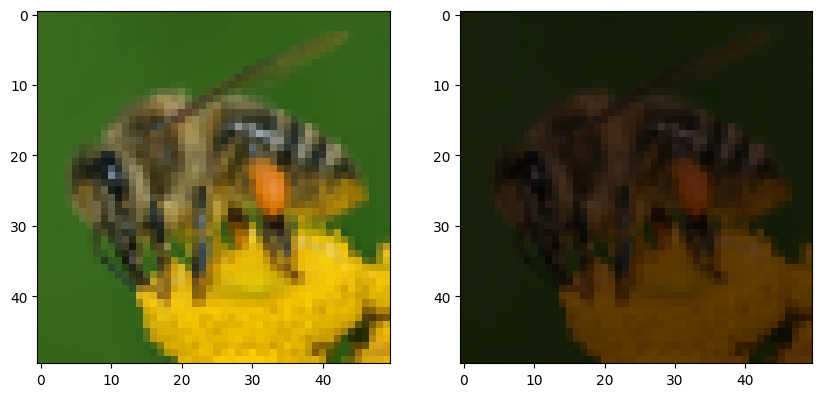

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(img)
axs[1].imshow(img_2)

## Dropout

In [22]:
def show_img(img, title="Image"):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [23]:
def dropout_np(img, factor=0.5):
    random_tensor = np.random.rand(*img.shape)
    dropout_mask = (random_tensor > factor).astype(np.uint8)
    return img * dropout_mask

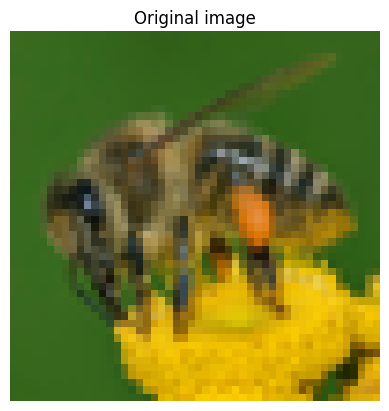

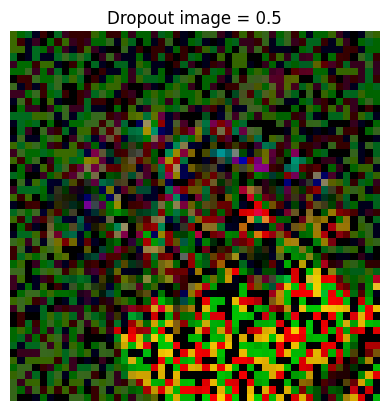

In [24]:
show_img(img, title="Original image")

dropped_img = dropout_np(img)
show_img(dropped_img, title="Dropout image = 0.5")

## Model Creation

In this step, two models will be created for training, one of them using a CNN with ResNet50 through the default functions of FastAi. Afterward, a manual model of CNN will be implemented.

### Resnet50

In [31]:
learn = vision_learner(dls, resnet50)
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,0.925499,0.246282,00:21


epoch,train_loss,valid_loss,time
0,0.334683,0.155669,00:27
1,0.213289,0.130147,00:27
2,0.200907,0.160475,00:27
3,0.197052,0.317123,00:27
4,0.152018,0.449554,00:27
5,0.149764,0.470055,00:27
6,0.124544,0.438809,00:27
7,0.126729,0.400076,00:27
8,0.114268,0.391392,00:27
9,0.102040,0.353229,00:27


### Manual Model

In [25]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [26]:
simple_cnn = sequential(
    conv(3 ,4),
    conv(4 ,8),
    conv(8 ,16),
    conv(16,32),
    conv(32,2, act=False),
    Flatten(),
    nn.Dropout(0.2),
)

In [27]:
learnCNN = Learner(dls, simple_cnn)

In [28]:
learnCNN.fine_tune(15)

epoch,train_loss,valid_loss,time
0,4.880307,4.850659,00:01


epoch,train_loss,valid_loss,time
0,4.847010,4.837866,00:01
1,4.837425,4.810141,00:01
2,4.815713,4.714650,00:01
3,4.735840,4.202478,00:01
4,4.468421,2.723088,00:01
5,4.085181,1.879319,00:01
6,3.760900,1.758451,00:01
7,3.532819,1.819508,00:01
8,3.322409,1.794826,00:01
9,3.174668,1.744804,00:01


With this, it is possible to see the difference between a model the uses resnet50 and a model that uses CNNs, where the CNN model converges better than the resnet50 model.

## Exporting

Now we can save both models for future usage, separating between two files **resnet.pkl** and **cnn.pkl**:

In [97]:
# Save resnet50 model
learn.export('resnet.pkl')

# Save CNN model
learnCNN.export('cnn.pkl')